# **Credit Risk Modeling - LGD and EAD Models**

In the first part of our project, we preprocessed data and prepared it to build a PD model and validated it in the second part in which we created scorecards too. In the third part, we did some monitoring of the model using new data. This work up to now is very important because probability of default modeling is the most volitale component of the expected loss. Now it's the time to estimate the other two components: Loss Given Default (LGD) and Exposure At Default (EAD). First, we start with the same preprocessing we've already done.  

### **Import libraries**

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import scipy.stats as stat

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Load and explore the data**

In [2]:
# let's load the preprocessed data 
# in the first part, we stored the preprocessed train and test sets separately
# to get the full dataset I concatenated all the sets
loan_data_inputs_train = pd.read_csv('C:/Users/Aylan/Documents/IT/Datasets/loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('C:/Users/Aylan/Documents/IT/Datasets/loan_data_inputs_test.csv')
loan_data_targets_train = pd.read_csv('C:/Users/Aylan/Documents/IT/Datasets/loan_data_targets_train.csv')
loan_data_targets_test = pd.read_csv('C:/Users/Aylan/Documents/IT/Datasets/loan_data_targets_test.csv')
df_inputs = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
df_targets = pd.concat([loan_data_targets_train, loan_data_targets_test], axis = 0)

In [3]:
df_inputs.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,mths_since_last_record_factor: > 76,total_rev_hi_lim_factor,total_rev_hi_lim:<=5K,total_rev_hi_lim:5K-10K,total_rev_hi_lim:10K-20K,total_rev_hi_lim:20K-30K,total_rev_hi_lim:30K-40K,total_rev_hi_lim:40K-55K,total_rev_hi_lim:55K-95K,total_rev_hi_lim:>95K
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,0.0,"(54999.994, 59999.994]",0,0,0,0,0,0,1,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0.0,"(9999.999, 14999.998]",0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0.0,"(29999.997, 34999.996]",0,0,0,0,1,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0.0,"(9999.999, 14999.998]",0,0,1,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0.0,"(5000.0, 9999.999]",0,1,0,0,0,0,0,0


In [4]:
df_targets.head()

,Unnamed: 0,good_bad
0,427211,1
1,206088,1
2,136020,1
3,412305,1
4,36159,0


In [5]:
# we can notice that the "df_targets" dataframe has the an extra column "Unnamed: 0" which stores the original indices
# since we have that information in the "df_inputs" dataframe we can remove it from the "df_targets" dataframe
df_targets.drop(['Unnamed: 0'], axis = 1, inplace = True)

# print the result
df_targets.head()

,good_bad
0,1
1,1
2,1
3,1
4,0


In [6]:
# now we can concatenate the inputs and targets dataframes
loan_data_2007_2014_preprocessed = pd.concat([df_inputs, df_targets], axis = 1)

# display the concatenated dataframe
pd.options.display.max_columns = None
loan_data_2007_2014_preprocessed.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mth_since_earliest_cr_line,issue_date,mth_issue_date,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ_smb_wedd_renen_mov_house,purpose:oth_med_vacation,purpose:majorpurch_car_homeimpr,term:36,term:60,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mth_issue_date_factor,mth_issue_date:<38,mth_issue_date:38-39,mth_issue_date:40-41,mth_issue_date:42-48,mth_issue_date:49-52,mth_issue_date:53-64,mth_issue_date:65-84,mth_issue_date:>84,int_rate_factor,int_rate: < 9.548,int_rate:9.548 - 12.025,int_rate:12.025 - 15.74,int_rate:15.74 - 20.281,int_rate: > 20.281,funded_amnt_factor,annual_inc_facto

In [7]:
# next step is to set the original index information from the "Unnamed: 0" column
loan_data_2007_2014_preprocessed = loan_data_2007_2014_preprocessed.set_index('Unnamed: 0')
loan_data_2007_2014_preprocessed.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mth_since_earliest_cr_line,issue_date,mth_issue_date,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ_smb_wedd_renen_mov_house,purpose:oth_med_vacation,purpose:majorpurch_car_homeimpr,term:36,term:60,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mth_issue_date_factor,mth_issue_date:<38,mth_issue_date:38-39,mth_issue_date:40-41,mth_issue_date:42-48,mth_issue_date:49-52,mth_issue_date:53-64,mth_issue_date:65-84,mth_issue_date:>84,int_rate_factor,int_rate: < 9.548,int_rate:9.548 - 12.025,int_rate:12.025 - 15.74,int_rate:15.74 - 20.281,int_rate: > 20.281,funded_amnt_factor,annual_inc_factor,annual_in

In [8]:
# make a copy of the data
loan_data_preprocessed = loan_data_2007_2014_preprocessed.copy() 

In [9]:
# to build the LGD, we need to see the percentage of the exposure that was lost after the borrower defaulted
# to build the EAD, we need to see the amount of the exposure at the moment the borrower defaulted 
# these data exist and can only be seen for the accounts that have been defaulted
# furthermore, it wouldn't be entirely accurate to include all of the defauted accounts for modeling loss given default or exposure at default
# this is because after a borrower has defaulted they can repay part of the debt so the lender can recover part of the amount they thought would be lost
# therefore, when building LGD and EAD models, it is a good practice to build models with data from borrowers that have had enough time to repay part of the remaining debt
# in our data, these are the accounts that were written off
# their "loan-status" is: "Charged Off" and "Does not meet the credit policy. Status:Charged Off." 
# by selecting only these observations, we will have the data for building the LGD and EAD models
# let's store these data in a new dataframe named "loan_data_defaults"
loan_data_defaults = loan_data_2007_2014_preprocessed[loan_data_2007_2014_preprocessed['loan_status'].isin(['Charged Off',
                                                                                                            'Does not meet the credit policy. Status:Charged Off'])]
# print the shape of the "loan_data_defaults" dataframe
loan_data_defaults.shape

(43236, 329)

In [10]:
# as we can see, there are 43236 of such defaulted accounts
# the independant variables we are going to use for the LGD and EAD are the same that we used for the PD
# let's recall that in the process of building the PD model, we disregarded many the initial available variables
# let's check of there are still some missing values in any of the variables we intend to use
pd.options.display.max_rows = None
loan_data_2007_2014_preprocessed.isnull().sum()

Unnamed: 0.1                                                            0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           27588
emp_length                                                          21008
home_ownership                        

In [11]:
# we can see that there are many missing values in many variables we won't be using
# some of which we turned into some reusable variables
# the only variables with missing values we intend to use are "mths_since_last_delinq" and "mths_since_last_record"
# from the PD model, ech of these variables had a lot of missing values
# it was necessary to have only dummy variables as independant variables, so it made sense to create a dummy variable for missing values
# the LGD and EAD models are not required to be easy to comprehend since only risk modelers use them
# hence, the independant variables in LGD and EAD models do not have to be only dummy variables like in the PD model 
# this means that we are going to create dummy variables for the categories of the discrete variables,
# but this time we won't care about the weight of evidence or any other criteria to group the categories
# rather, for the discrete variables we simply create as many dummy variables as the number of categories 
# when it comes to continuous variables we can use them for the LGD and EAD models as they are or transform them. There is no need for fine classing and coarse classing
# the variables "mths_since_last_delinq" and "mths_since_last_record" will be included as continuous variables in our new models
# however, we still have the missing values problem so we will have to impute them
# for now, to not complicate things too muchn it would be sufficient to impute them to 0s (taking the most conservative approach to risk)
loan_data_2007_2014_preprocessed['mths_since_last_delinq'] = loan_data_2007_2014_preprocessed['mths_since_last_delinq'].fillna(0)
loan_data_2007_2014_preprocessed['mths_since_last_record'] = loan_data_2007_2014_preprocessed['mths_since_last_record'].fillna(0)

In [12]:
# after getting the independant variables, we need to get the dependant variable for the LGD and EAD models
# we usually work on one of these models at a time
# for convenience we are going to use one dataset for storing data for both models
# let's start with Loss Given Default (LGD)
# LGD is the share of an asset that is lost if a borrower defaults
# it is the proportion of the total exposure that can be recovered by the lender once a default has occurred
# the approach is to model the proportion of the total exposure that can be recovered by the lender once the default has occurred
# this proportion is called recovery rate after which the LGD can be calculated easily because it equals one minus the recovery rate for each exposure
# so let's calculate the recovery rate for our data
# we can find the amount recovered in the column "recoveries"
# we assumed that for the defaulted borrowers "funded_amnt" reflects the total amount that was lost the moment the borrower defaulted
# so we can calculate the recovery rate as the proprtion of the funded amount that has been recovered
loan_data_2007_2014_preprocessed['recovery_rate'] = loan_data_2007_2014_preprocessed['recoveries'] / loan_data_2007_2014_preprocessed['funded_amnt']

# let's use the df.describe() method to see what values we get
loan_data_2007_2014_preprocessed['recovery_rate'].describe()

count    466285.000000
mean          0.005640
std           0.032533
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.220774
Name: recovery_rate, dtype: float64

In [13]:
# we can see that the max value is higher than 1, but this is a rate so it should be bounded between 0 and 1
# sometimes this happens when the data has erroneous information due to bad calculations for example
# in this case we can truncate (cast) the values outside this range to either 0 or 1 
loan_data_2007_2014_preprocessed['recovery_rate'] = np.where(loan_data_2007_2014_preprocessed['recovery_rate'] > 1, 1, loan_data_2007_2014_preprocessed['recovery_rate'])
loan_data_2007_2014_preprocessed['recovery_rate'] = np.where(loan_data_2007_2014_preprocessed['recovery_rate'] < 0, 0, loan_data_2007_2014_preprocessed['recovery_rate'])

# use the df.describe() method again to see the values
loan_data_2007_2014_preprocessed['recovery_rate'].describe()

count    466285.000000
mean          0.005635
std           0.032380
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: recovery_rate, dtype: float64

In [14]:
# now we are sure that the recovery_rate lies in the range of 0 and 1
# "recovery_rate" is the dependant variable for the LGD model and we have successfully preprocessed it
# let's now focus our attention on the Exposure At Default (EAD)
# EAD is the total value that a lender is exposed to when a borrower defaults
# therefore, it is the maximum that a bank may lose when a borrower defaults on a loan
# also the borrower may only have defaulted on a proportion of the original funded amount
# that proportion is going to be our dependant variable for the exposure at default model
# most often, the proportion is called credit conversion factor
# the exposure default can be calculated easily because it equals the total funded amount multiplied by the credit conversion factor
# we'll use the "Total recovered principal" column which reflects the total payments made on the principal of the loan 
# let's calculate the credit conversion factor which we will cal "CCF"
# if all is paid, CCF = 0, if nothing has been paid, CCF = 1
loan_data_2007_2014_preprocessed['CCF'] = (loan_data_2007_2014_preprocessed['funded_amnt'] - loan_data_2007_2014_preprocessed['total_rec_prncp']) / loan_data_2007_2014_preprocessed['funded_amnt']

# let's use the df.describe() method to see what values we get
loan_data_2007_2014_preprocessed['CCF'].describe()

count    466285.000000
mean          0.344844
std           0.327627
min          -0.021734
25%           0.000000
50%           0.347625
75%           0.643997
max           1.000000
Name: CCF, dtype: float64

In [15]:
# we can see that the minimum value is about -0.021734. This value shouldn't be outside the range of 0 and 1
# in this case we can also truncate (cast) the values outside this range to either 0 or 1 
loan_data_2007_2014_preprocessed['CCF'] = np.where(loan_data_2007_2014_preprocessed['CCF'] > 1, 1, loan_data_2007_2014_preprocessed['CCF'])
loan_data_2007_2014_preprocessed['CCF'] = np.where(loan_data_2007_2014_preprocessed['CCF'] < 0, 0, loan_data_2007_2014_preprocessed['CCF'])

# let's use the df.describe() method again to see what values we get
loan_data_2007_2014_preprocessed['CCF'].describe()

count    466285.000000
mean          0.344844
std           0.327627
min           0.000000
25%           0.000000
50%           0.347625
75%           0.643997
max           1.000000
Name: CCF, dtype: float64

In [16]:
# the "CCF" variable lies in the range of 0 and 1
# let's export the "loan_data_2007_2014_preprocessed" to a csv file which I renamed "loan_data_2007_2014_defaults"
# loan_data_2007_2014_preprocessed.to_csv('/content/drive/My Drive/Colab Notebooks/Database/loan_data_2007_2014_defaults.csv')

### **Explore the dependant variables**

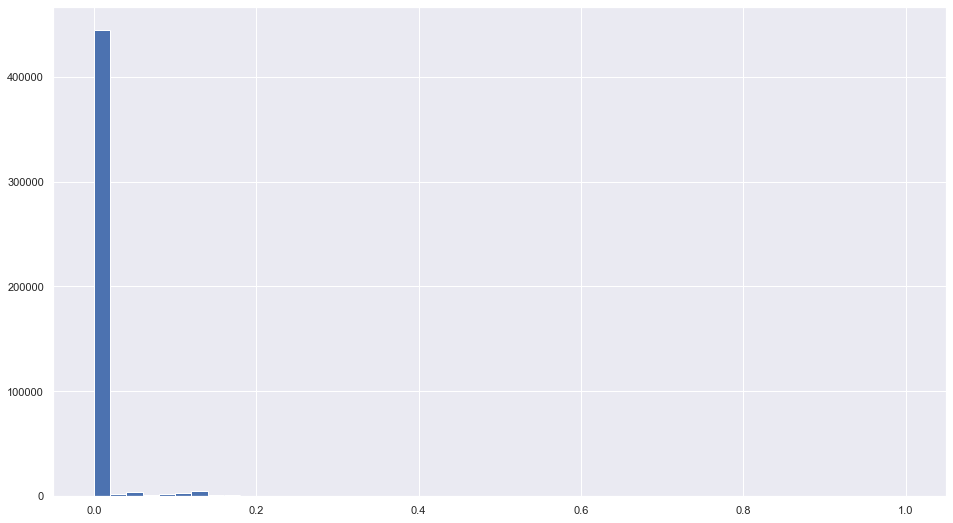

In [17]:
# let's now explore the dependant variables visually
# first we visualize a histogram of the "recovery_rate" and "CCF" columns
plt.figure(figsize = (16,9))
plt.hist(loan_data_2007_2014_preprocessed['recovery_rate'], bins = 50)
plt.show()

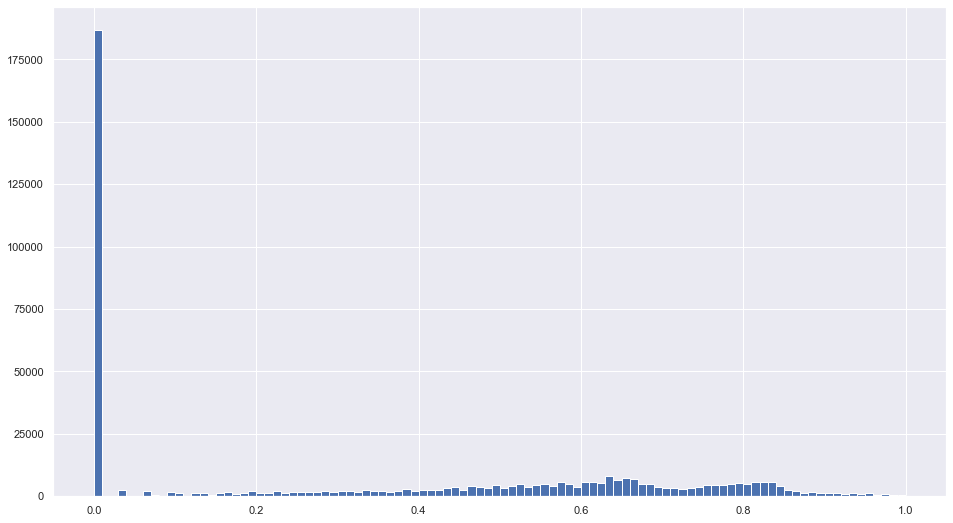

In [18]:
plt.figure(figsize = (16,9))
plt.hist(loan_data_2007_2014_preprocessed['CCF'], bins = 100)
plt.show()

In [19]:
# we can notice that half of the proportions in the "recovery_rate" column are 0s
# therefore, I used a two-stage approach
# 1) is recovery rate equal to 0 or greater than 0? (this is a binary question so we use a logistic regression)
# 2) if recovery rate is greater than 0, how much exactly is it? (we use a linear regression)

# for the logisitic regression model we will create a new binary dependant variable
loan_data_2007_2014_preprocessed['recovery_0_1'] = np.where(loan_data_2007_2014_preprocessed['recovery_rate'] == 0, 0, 1)

# display the column
loan_data_2007_2014_preprocessed['recovery_0_1'].head()

Unnamed: 0
427211    0
206088    0
136020    0
412305    0
36159     1
Name: recovery_0_1, dtype: int32

In [20]:
# once this is done, we can only take where the accounts where the recovery rate is greater than 0 and model how much exactly it is
# the easiest way to do that is with linear regression
# now for EAD, we need to note that credit conversion factors are more homogeneously distributed
# applying directly a linear regression model to model credit conversion factors would produce satisfactory results 
# so for credit conversion factors we will use a multiple linear regression model

### **LGD Model**

It's time to build our LGD model. First we are going to create a logisitic regression model to estimate if the recovery rate is 0 or greater than 0. Then, for accounts where the recovery rate is greater than 0 we'll use a linear regression model to calculate the exact value. To test how our model performs we need a test data, so we are going to split our data into train and test datasets.

In [21]:
# splitting the data
# we will drop the columns we know are dependant variables
# the target variable for the LGD model is "recovery_rate_0_1"
lgd_inputs_stage1_train, lgd_inputs_stage1_test, lgd_targets_stage1_train, lgd_targets_stage1_test = train_test_split(loan_data_2007_2014_preprocessed.drop(['good_bad',
                                                                                                                                                             'recovery_rate',
                                                                                                                                                             'recovery_0_1',
                                                                                                                                                             'CCF'], axis = 1),
                                                                                                                      loan_data_2007_2014_preprocessed['recovery_0_1'],
                                                                                                                      test_size = 0.3,
                                                                                                                      random_state = 365)

# preparing the inputs
# as we won't need all the variables we just split, we'll organize them in a list named "features_all"
# in this list we will include all the dummies and continuous variable that will serve as predictors for our LGD model
# in any regression model, a categorical variable with k categories is represented by k-1 dummy variables
features_all = ['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G', 'home_ownership:MORTGAGE', 'home_ownership:NONE', 
                'home_ownership:OTHER', 'home_ownership:OWN', 'home_ownership:RENT', 'verification_status:Not Verified',
                'verification_status:Source Verified', 'verification_status:Verified', 'purpose:car', 'purpose:credit_card', 'purpose:debt_consolidation',
                'purpose:educational', 'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
                'purpose:other', 'purpose:renewable_energy', 'purpose:small_business', 'purpose:vacation', 'purpose:wedding', 'initial_list_status:f',
                'initial_list_status:w', 'emp_length_int', 'term_int', 'mth_issue_date', 'mth_since_earliest_cr_line', 'funded_amnt', 'int_rate',
                'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
                'pub_rec', 'total_acc', 'acc_now_delinq', 'total_rev_hi_lim']

# the reference categories are stored in a variable I named "ref_cat"
ref_cat = ['grade:G', 'home_ownership:RENT', 'verification_status:Verified', 'purpose:credit_card', 'initial_list_status:f']

# update the train dataset
lgd_inputs_stage1_train = lgd_inputs_stage1_train[features_all]

# update the train dataset again and remove the reference categories
lgd_inputs_stage1_train.drop(ref_cat, axis = 1, inplace = True)

**Stage 1 - Logistic Regression**

In [22]:
# now we need to test our model
# the logistic regression class in sklearn is not able to give us p-values. For the PD model, we had to alter it and we will do the same here
# I copied the code I wrote previously here
class LogisticRegression_with_p_values:

  def __init__(self, *args, **kwargs):
    self.model = linear_model.LogisticRegression(*args, **kwargs)
  
  def fit(self, X, y):
    self.model.fit(X, y)
    denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
    denom = np.tile(denom, (X.shape[1], 1)).T
    F_ij = np.dot((X / denom).T, X)
    Cramer_Rao = np.linalg.inv(F_ij)
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = self.model.coef_[0] / sigma_estimates
    p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
    self.coef_ = self.model.coef_
    self.intercept_ = self.model.intercept_
    self.p_values = p_values

In [23]:
# then we use this class to fit the model
lgd_stage_1 = LogisticRegression_with_p_values()
lgd_stage_1.fit(lgd_inputs_stage1_train, lgd_targets_stage1_train)

C:\Users\Aylan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# display a summary table with regression coefficients and their p_values
feature_name = lgd_inputs_stage1_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature Name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(lgd_stage_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', lgd_stage_1.intercept_[0]]
p_values = lgd_stage_1.p_values
p_values = np.append(np.nan, np.array(p_values))
summary_table['P_Values'] = p_values
summary_table

,Feature Name,Coefficients,P_Values
1,grade:A,-8.559230e-04,NaN
2,grade:B,-1.133749e-03,9.891740e-01
3,grade:C,-4.963921e-04,9.853228e-01
4,grade:D,2.306822e-04,9.939044e-01
5,grade:E,4.182138e-04,9.974000e-01
6,grade:F,3.620061e-04,9.958417e-01
7,home_ownership:MORTGAGE,-3.336123e-04,9.969849e-01
8,home_ownership:NONE,2.486196e-06,9.845880e-01
9,home_ownership:OTHER,5.461035e-06,9.999969e-01
10,home_ownership:OWN,-1.588688e-04,9.999852e-01


In [25]:
# let's explore the regression coefficients
# most of them aren't statistically significant
# in other words, in we get these variables out of the model, the predictive power won't change
# I prefered to leabe them out in order to simplify the model
# now let's interperet some coefficients
# the only difference if we compare to the PD model, is that we have continuous variables,
# their coeffcients reflect the change in log-odds that results from a unit change in the property the continuous variable measures
# for example, for every unit increase in funded amount, the log odds will increase by about 0.0001
# for every unit increase in debt-to-income (dti), the log odds will decrease by 0.0176
# now it's time to make the model predictions
# first we need to update the test dataset the same way we updated the train dataset
lgd_inputs_stage1_test = lgd_inputs_stage1_test[features_all]
lgd_inputs_stage1_test.drop(ref_cat, axis = 1, inplace = True)

# use the model's prediction method to predict the targets
y_pred_stage_1 = lgd_stage_1.model.predict(lgd_inputs_stage1_test)

# display the predicted variable
y_pred_stage_1

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
# unfortunately the model predicted only 0s at this point
# what we got are raw data about the recovery rate
# let's get the estimated probabilities of the recovery rate value
y_pred_proba = lgd_stage_1.model.predict_proba(lgd_inputs_stage1_test)

# display the predicted variable
y_pred_proba

array([[0.9041924 , 0.0958076 ],
       [0.9581043 , 0.0418957 ],
       [0.95184135, 0.04815865],
       ...,
       [0.92225935, 0.07774065],
       [0.91640094, 0.08359906],
       [0.96342701, 0.03657299]])

In [27]:
# the probability predictions in the result above contains two columns with many rows
# the second column contains the probabilities of the recovery rate greater than 0
y_pred_proba_greater_zero = y_pred_proba[:, 1]
y_pred_proba_greater_zero

array([0.0958076 , 0.0418957 , 0.04815865, ..., 0.07774065, 0.08359906,
       0.03657299])

In [28]:
# to reassess the accuracy of our model we need to compare with the actual values or the test targets
# first let's concatenate the predicted values with their probabilities
lgd_targets_stage1_test_temp = lgd_targets_stage1_test # create a temporary variable
lgd_targets_stage1_test_temp.reset_index(drop = True, inplace = True) # reset the indices
df_pred_proba = pd.concat([lgd_targets_stage1_test_temp, pd.DataFrame(y_pred_proba_greater_zero)], axis = 1) # concatenate the 
df_pred_proba.columns = ['lgd_targets_stage1_test', 'y_pred_proba_greater_zero'] # rename the columns
df_pred_proba.index = lgd_targets_stage1_test.index # make sure we keep the original indices
df_pred_proba.head() # display the concatenated dataframe

,lgd_targets_stage1_test,y_pred_proba_greater_zero
0,1,0.095808
1,1,0.041896
2,0,0.048159
3,1,0.122556
4,0,0.084122


In [29]:
# we will assess the accuracy using the same methodology we used for the PD model
# I used a threshold tr = 0.1
tr = 0.1
df_pred_proba['y_pred_test'] = np.where(df_pred_proba['y_pred_proba_greater_zero'] > tr, 1, 0)

# print a confusion matrix
pd.crosstab(df_pred_proba['lgd_targets_stage1_test'], df_pred_proba['y_pred_test'],
            rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,115749,16839
1,5862,1436


In [30]:
# calculate the overall accuracy
accuracy = accuracy_score(df_pred_proba['y_pred_test'], df_pred_proba['lgd_targets_stage1_test'])
accuracy

0.8377178559684314

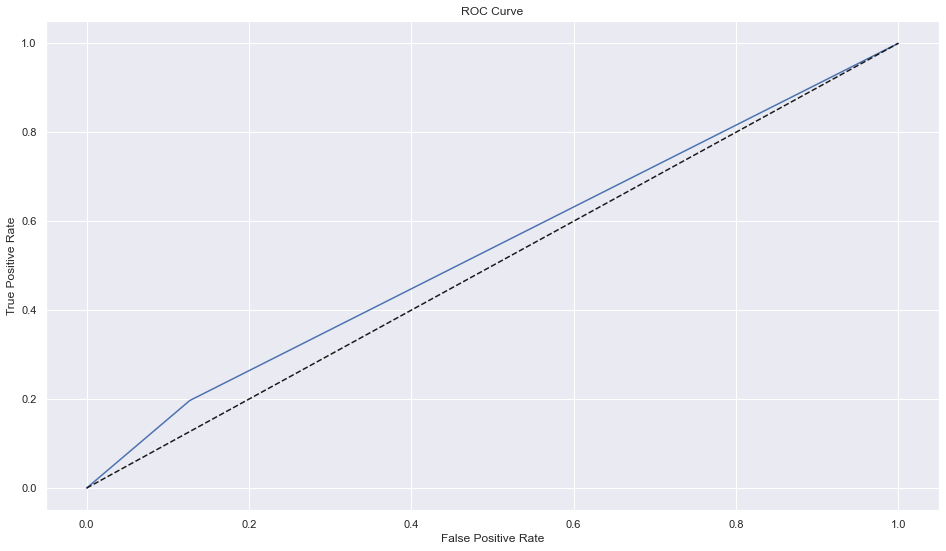

In [31]:
# with a thresshold of tr = 0.1 the model predicted 1559 observations with a recovery rate greater than 0 while it incorrectly classified 17346 observations as equal to 0
# the overall accuracy is about 85% 
# however, accuracy at a given cut-off is not as informative as the receiver operating characteristic (ROC) curve
# let's calculate the roc and the auc
fpr, tpr, threshold = roc_curve(df_pred_proba['lgd_targets_stage1_test'], df_pred_proba['y_pred_test'])

# plot the ROC curve
plt.figure(figsize = (16,9))
plt.plot(fpr, tpr) # ROC curve
plt.plot(fpr, fpr, linestyle = '--', color = 'k') # benchmark (predicting by chance)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [32]:
# calculate the area under the curve (AUC)
auroc = roc_auc_score(df_pred_proba['lgd_targets_stage1_test'], df_pred_proba['y_pred_test'])
auroc

0.5348818968326174

In [33]:
# since the model predicted a total of 18905 observations as 1s I decided to assign this result to "y_pred_stage_1"
y_pred_stage_1 = np.array(df_pred_proba['y_pred_test'])

In [34]:
# the auc is about 54% which is not that great
# however we will use this model as the first stage of estimating LGD
# therefore, it is important to have a large proportion of correctly classified values that are greater than 0 than to have correctly classified 0s
# the reason is during the 2nd stage some of the values classified as > 1 may be estimated to be 0, thus correcting the current miscalculation
# now it's time to save the model into a file
# this ML model now contains information like the coefficients and intercept, the random state that was chosen for the shuffling was 0
pickle.dump(lgd_stage_1, open('C:/Users/Aylan/Documents/IT/Datasets/lgd_stage_1.sav', 'wb'))

**Stage 2 - Linear Regression**

In [35]:
# in this section we will build a linear regression model to determine that exact recovery rate of observations that are predicted to be above 0
# the model will be a multiple regression model
# recall that all borrowers with recovery rate > 0 were encoded as 1 in the "recovery_0_1" column
# let's create a new dataframe that will contain all borrowers with recovery rate > 0
data_stage_2 = loan_data_2007_2014_preprocessed[loan_data_2007_2014_preprocessed['recovery_0_1'] == 1]

# then we split the data into train and test sets once more
lgd_inputs_stage2_train, lgd_inputs_stage2_test, lgd_targets_stage2_train, lgd_targets_stage2_test = train_test_split(data_stage_2.drop(['good_bad',
                                                                                                                                        'recovery_rate',
                                                                                                                                        'recovery_0_1',
                                                                                                                                        'CCF'], axis = 1),
                                                                                                                      data_stage_2['recovery_rate'], 
                                                                                                                      test_size = 0.3,
                                                                                                                      random_state = 365) 

# similar to the logistic regression clas, the linear regression class does not show p-values for the estimated regression coefficients
# so to see the p-values we must alter it as we did for the logistic regression method 
# below is the code I wrote for the linear regression class
class LinearRegression(linear_model.LinearRegression):
  """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are tandp which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
  def __init__(self, fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1):
    super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)
    self.fit_intercept = fit_intercept
    self.normalize = normalize
    self.copy_X = copy_X
    self.n_jobs = n_jobs
  def fit(self, X, y, n_jobs = 1):
    self = super(LinearRegression, self).fit(X, y, n_jobs)
    sse = np.sum((self.predict(X) - y) ** 2, axis = 0) / float(X.shape[0] - X.shape[1])
    se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
    self.t = self.coef_ / se
    self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
    return self

# now we can proceed to estimating the model
# let's preselect only the input variables we need
lgd_inputs_stage2_train = lgd_inputs_stage2_train[features_all]

# remove the reference categories
lgd_inputs_stage2_train.drop(ref_cat, axis = 1, inplace = True)

In [36]:
# now let's fit the model
lgd_stage_2 = LinearRegression()
lgd_stage_2.fit(lgd_inputs_stage2_train, lgd_targets_stage2_train) 

C:\Users\Aylan\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [37]:
# display a summary table with regression coefficients and their p_values
feature_name = lgd_inputs_stage2_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature Name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(lgd_stage_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', lgd_stage_2.intercept_]
p_values = lgd_stage_2.p
p_values = np.append(np.nan, np.array(p_values))
summary_table['P_Values'] = p_values.round(3)
summary_table

,Feature Name,Coefficients,P_Values
1,grade:A,-8.452372e-02,NaN
2,grade:B,-6.676418e-02,0.000
3,grade:C,-5.295513e-02,0.000
4,grade:D,-3.956201e-02,0.000
5,grade:E,-2.206204e-02,0.000
6,grade:F,-9.466237e-03,0.000
7,home_ownership:MORTGAGE,1.884116e-03,0.069
8,home_ownership:NONE,-7.728126e-03,0.245
9,home_ownership:OTHER,-1.980578e-02,0.851
10,home_ownership:OWN,7.521972e-03,0.405


In [38]:
# the coefficients for the second stage of our model are statistically significant
# interpretation of the coefficients: a coefficient shows the change in the dependant variable that is going to occur as a result of a unit change in the respective independant variable
# for example, if the purpose of the loan is "educational", it is expected that the recovery rate would be 6.3% higher 
# also, each dollar increase in anual income is expected to result in 0.0000072% higher recovery rate
# moreover, every percentage increase in interest rate is expected to result in 2.69% lower recovery
# now let's see how well this linear model predicts recovery rates > 0
# first we need to update the test dataset the same way we updated the train dataset
lgd_inputs_stage2_test = lgd_inputs_stage2_test[features_all]
lgd_inputs_stage2_test.drop(ref_cat, axis = 1, inplace = True)

# use the model's prediction method to predict the targets
y_pred_stage_2 = lgd_stage_2.predict(lgd_inputs_stage2_test)

# display the predicted variable
y_pred_stage_2

array([0.1411718 , 0.11013773, 0.16466488, ..., 0.07972777, 0.05546323,
       0.10873409])

In [39]:
# let's use the correlation between actual and predicted values as a proxy of model performance
lgd_targets_stage2_test_temp = lgd_targets_stage2_test # create a temporary variable
lgd_targets_stage2_test_temp.reset_index(drop = True, inplace = True) # reset the indices

# concatenate this variable with the predicted values and calculate the correlation
pd.concat([lgd_targets_stage2_test_temp, pd.DataFrame(y_pred_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.311278
0,0.311278,1.000000


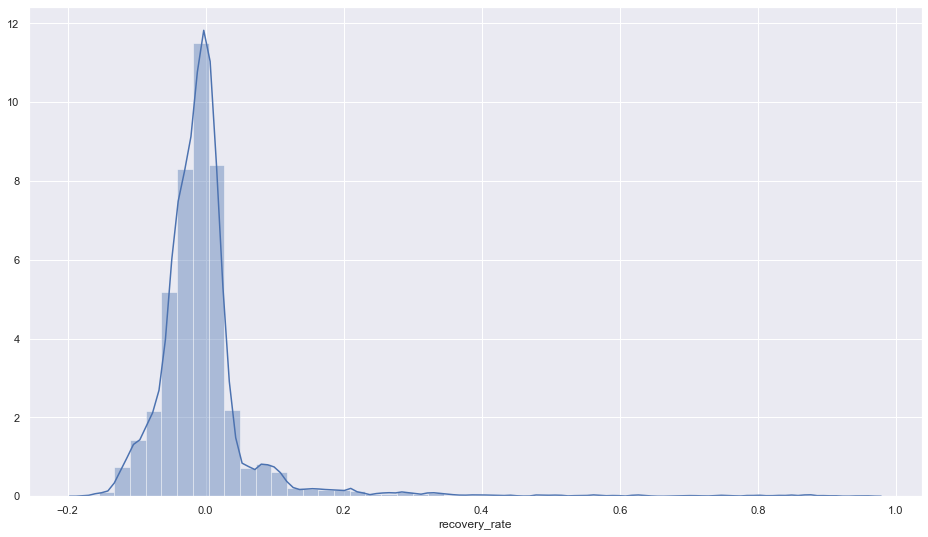

In [40]:
# the correlation between the actual and predicted values is about 0.31
# this is weak to moderate correlation in general but satisfactory for an LGD model
# if the correlation was too high we would've questioned the methodology
# let's assess our model in another way
# we can look at the distribution between actual and predicted values called residuals
# if everything is ok this distribution would be a normal distribution and we'll have a mean of 0
# let's plot the disctribution
plt.figure(figsize = (16,9))
sns.distplot(lgd_targets_stage2_test - y_pred_stage_2) # difference between actual and predicted values

In [41]:
# we can that the distribution ressembles a normal distribution and most of the residuals are symmitrically distributed around 0
# 0 is also the place where most of these residuals are concentrated 
# this seems a good model methodologically
# let's save this model 
pickle.dump(lgd_stage_2, open('C:/Users/Aylan/Documents/IT/Datasets/lgd_stage_2.sav', 'wb'))

**Combining stage 1 and stage 2**

In [42]:
# now that we finished with the second stage, we must combine the two stages to reach the actual LGD model
# we need to estimated the recovery rate by the linear regression no matter if they were predicted to be 0 or 1 by the first stage
y_pred_stage_2 = lgd_stage_2.predict(lgd_inputs_stage1_test)
y_pred_stage_2

array([0.14163436, 0.05708556, 0.09721441, ..., 0.06121664, 0.15441002,
       0.16347121])

In [43]:
# now we must obtain the combined recovery rate applying the stage 1 model first and then the stage 2 model
# so every observation classified as 0 by the stage 1 logistic regression model has estimated recovery rate of 0
# and every observation classified as 1 by the stage 1 logisitc regression model has estimated recovery rate as per the stage 2 linear regreession model
# we can reach the combined estimation by simply multiplying the predicted values from the two models 
# wherever there is a 0 predicted by the first model, all values predicted by the second model are multiplied by it will remain 0,
# and wherever there is a 1, all values predicted by the second model are multiplied by 1 so they'll remain the same 
y_pred_all = y_pred_stage_1 * y_pred_stage_2

# let's take a look at the describtives of the "y_pred_test" dataframe
pd.DataFrame(y_pred_all).describe()

,0
count,139886.000000
mean,0.012579
std,0.034476
min,-0.015017
25%,0.000000
50%,0.000000
75%,0.000000
max,0.190727


In [44]:
# we can see that the minimum value is negative which means that there some negative values
# the linear regression model is not contrained to produce values only between 0 and 1
# to remedy this problem, we can set all the values lower than 0 to 0 and set all the values higher than equal to 1
y_pred_all = np.where(y_pred_all < 0, 0, y_pred_all)
y_pred_all = np.where(y_pred_all > 1, 1, y_pred_all)

# print again the describtives of the "y_pred_test" dataframe
pd.DataFrame(y_pred_all).describe()

,0
count,139886.000000
mean,0.012579
std,0.034475
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.190727


### **EAD Model**

In [45]:
# it's time to build the model that is going to give us the final exponent of expected loss (EAD)
# the dependant variable for the EAD model is the credit conversion factor (CCF):
# the CCF is the proportion for the original amount of the loan that is still outstanding at the moment when the borrower defaulted 
# once again we need to split our data into train and test sets
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_2007_2014_preprocessed.drop(['good_bad',
                                                                                                                                 'recovery_rate',
                                                                                                                                 'recovery_0_1',
                                                                                                                                 'CCF'], axis = 1),
                                                                                          loan_data_2007_2014_preprocessed['CCF'], # CCF is our target variable
                                                                                          test_size = 0.3,
                                                                                          random_state = 365)

# the list "features_all" contains all variables relevant for the regression
# update the inputs
ead_inputs_train = ead_inputs_train[features_all]

# a ctagorical variable with k categories is represented by only k-1 dummies
# for the EAD model it doesn't matter which category is the reference one 
# therefore, for convenience we can employ the same reference categories as we did for the LGD model
# we stored their names in the "ref_cat" list
# so let's drop the reference categories from the inputs
ead_inputs_train.drop(ref_cat, axis = 1, inplace = True)

# now the inputs variable contains only the variables we need for the model
# now we will use the linear regression class we created previously to build our model
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

C:\Users\Aylan\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [46]:
# as usual, we will make a summary table
feature_name = ead_inputs_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature Name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
p_values = reg_ead.p
p_values = np.append(np.nan, np.array(p_values))
summary_table['P_Values'] = p_values.round(3)
summary_table

,Feature Name,Coefficients,P_Values
1,grade:A,-5.485019e-01,NaN
2,grade:B,-4.519703e-01,0.000
3,grade:C,-3.400490e-01,0.000
4,grade:D,-2.434819e-01,0.000
5,grade:E,-1.471028e-01,0.000
6,grade:F,-5.901540e-02,0.000
7,home_ownership:MORTGAGE,-1.838296e-02,0.000
8,home_ownership:NONE,4.355317e-02,0.000
9,home_ownership:OTHER,1.864926e-01,0.319
10,home_ownership:OWN,-3.437683e-03,0.000


In [47]:
# positive coefficients indicate an increase in the CCF, and higher CCFs indicate that amount of exposure at the moment of default would be higher (higher risk)
# negative coefficients indicate a decrease in the CCF, and lower CCFs indicate that amount of exposure at the moment of default would be lower (lower risk)
# we are now going to evaluate the EAD model and investigate how well the linear model predicts the CCF
# we will use the test data and update it the same way we did for the train data
ead_inputs_test = ead_inputs_test[features_all]
ead_inputs_test.drop(ref_cat, axis = 1, inplace = True)

# make the predictions
y_pred_ead = reg_ead.predict(ead_inputs_test)

# to assess how well the model predicts actual values we'll calculate the correlation between actual and predicted values
ead_targets_test_temp = ead_targets_test # create a temporary variable for the targets test variable
ead_targets_test_temp.reset_index(drop = True, inplace = True) # reset the indices
pd.concat([ead_targets_test_temp, pd.DataFrame(y_pred_ead)], axis = 1).corr() # concatenate the actual and predicted values and calculate the correlation

,CCF,0
CCF,1.000000,0.578369
0,0.578369,1.000000


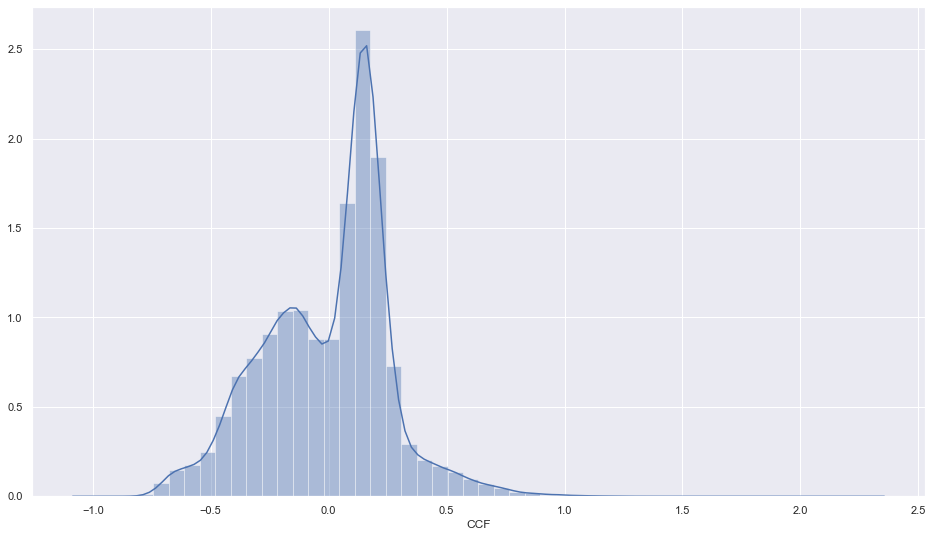

In [48]:
# the correlation coefficiant is about 0.58 which a relatively good correlation coefficient for an EAD model
# furthermore, we can look at the distribution of the residuals, i.e. the differences between actual and predicted values
# if everything is ok this dstribution will be close to a normal distribution and have a mean of 0
# let's plot the distribution
plt.figure(figsize = (16,9))
sns.distplot(ead_targets_test_temp - y_pred_ead) # predicted and actual values
plt.show()

In [49]:
# the predictive power relatively seems to be good and we can say that model is good enough methodologically
# finally let's look at the descriptives of the predicted values of the credit conversion factor
pd.DataFrame(y_pred_ead).describe()

,0
count,139886.000000
mean,0.345285
std,0.191449
min,-2.120989
25%,0.225379
50%,0.348185
75%,0.461530
max,1.140351


In [50]:
# the minimum value here is negative
# to remedy this problem, we can set all the values lower than 0 to 0 and set all the values higher than equal to 1
y_pred_ead = np.where(y_pred_ead < 0, 0, y_pred_ead)
y_pred_ead = np.where(y_pred_ead > 1, 1, y_pred_ead)

# let's print the descriptives again
pd.DataFrame(y_pred_ead).describe()

,0
count,139886.000000
mean,0.349964
std,0.180147
min,0.000000
25%,0.225379
50%,0.348185
75%,0.461530
max,1.000000


In [51]:
# the predicted values now lie in the interval [0,1]

**Comment:**  
Up to now we have successfully built a PD model, an LGD model and an EAD model. We are one step away from closing the credit risk modeling cycle of the bank. What we've got left is to calculate the final component which is the expected loss. So in the next step, we are going to integrate the outputs of these three models and calculate the expected loss.

### **Expected Loss**

In [52]:
# in order to calculate the expected loss, we need to multiply its three components 
# in other words, we multiply PD, LGD and EAD components, EL = PD * LGD * EAD
# previously we estimated the respective models of each of these three components
# so for given cutomer, we just need to calculate the PD, the LGD and EAD and calculate the expected loss
# banks dont't really care about the loss they'll experience from a single borrower
# this is simply because it is negligeable compared to the overall exposure
# that is why it is rather preferable to find the expected loss of all the borrowers which is simply the sum of the expected losses of all accounts
# in the beginning of this notebook I stored a copy of the original preprocessed dataset
# this data will be used to feed the three models and calculate the expected loss
loan_data_preprocessed.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mth_since_earliest_cr_line,issue_date,mth_issue_date,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ_smb_wedd_renen_mov_house,purpose:oth_med_vacation,purpose:majorpurch_car_homeimpr,term:36,term:60,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mth_issue_date_factor,mth_issue_date:<38,mth_issue_date:38-39,mth_issue_date:40-41,mth_issue_date:42-48,mth_issue_date:49-52,mth_issue_date:53-64,mth_issue_date:65-84,mth_issue_date:>84,int_rate_factor,int_rate: < 9.548,int_rate:9.548 - 12.025,int_rate:12.025 - 15.74,int_rate:15.74 - 20.281,int_rate: > 20.281,funded_amnt_factor,annual_inc_factor,annual_in

In [53]:
# let's creata nother copy for the lgd and ead models
#loan_data_preprocessed_lgd_ead = loan_data_preprocessed.copy()

# recall that the columns "mths_since_last_delinq" and "mths_since_last_record" had missing values
# we need to inpute them here as well before applying the models
loan_data_preprocessed['mths_since_last_delinq'] = loan_data_preprocessed['mths_since_last_delinq'].fillna(0)
loan_data_preprocessed['mths_since_last_record'] = loan_data_preprocessed['mths_since_last_record'].fillna(0)

# now the data we used for the LGD and EAD is the same, howerver it differs from that for the PD model
# therefore, I used a separate dataframe to apply the LGD and EAD models
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all] # update the df with the "features_all" list
loan_data_preprocessed_lgd_ead.drop(ref_cat, axis = 1, inplace = True) # remove the reference categories

# let's create two new columns in which we calculate predictions from the LGD stage 1 and LGD stage 2 models respectively
loan_data_preprocessed['recovery_rate_stage_1'] = lgd_stage_1.model.predict(loan_data_preprocessed_lgd_ead)
loan_data_preprocessed['recovery_rate_stage_2'] = lgd_stage_2.predict(loan_data_preprocessed_lgd_ead)

# now we multiply the results of these two columns
# wherever there is a 0 predicted by the first model, all values predicted by the second model are multiplied by it will remain 0,
# and wherever there is a 1, all values predicted by the second model are multiplied by 1 so they'll remain the same 
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_stage_1'] * loan_data_preprocessed['recovery_rate_stage_2']

# there is one last thing left to do
# we saw that linear regression models can produce outputs lower than 0 and higher than 1
# as before, we will make the same adjustments
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 0, 0, loan_data_preprocessed['recovery_rate'])

# at last, now we know that LGD = 1 - Recovery Rate
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

# check the descriptives of the "LGD" columns
loan_data_preprocessed['LGD'].describe()

C:\Users\Aylan\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


count    466285.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: LGD, dtype: float64

In [54]:
# let's move on to calculating EAD
# here, we use the linear regression for ead model to calculate the credit conversion factors
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

# the "CCF" column now contains the estimated credit conversion factors
# for the same reasons as above, we have to make the adequate adjustments
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

# we know that EAD = CCF * funded_amount
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed['funded_amnt']

# print the descropitives for the "EAD" column
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean       5478.023786
std        4919.937260
min           0.000000
25%        1865.963288
50%        3886.386974
75%        7852.734447
max       35000.000000
Name: EAD, dtype: float64

In [55]:
# we are now going to calculate the probability of default (PD)
# for PD we need an entirely different set of inputs variables
# they were all dummy variables we created specifically for the PD model
# first our dataframe needs to be the same as the one we used to build the PD model
# we have that dataframe by concatenating the original train and test inputs
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis =0)
loan_data_inputs_pd.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mth_since_earliest_cr_line,issue_date,mth_issue_date,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ_smb_wedd_renen_mov_house,purpose:oth_med_vacation,purpose:majorpurch_car_homeimpr,term:36,term:60,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mth_issue_date_factor,mth_issue_date:<38,mth_issue_date:38-39,mth_issue_date:40-41,mth_issue_date:42-48,mth_issue_date:49-52,mth_issue_date:53-64,mth_issue_date:65-84,mth_issue_date:>84,int_rate_factor,int_rate: < 9.548,int_rate:9.548 - 12.025,int_rate:12.025 - 15.74,int_rate:15.74 - 20.281,int_rate: > 20.281,funded_amnt_factor,annual_inc_facto

In [56]:
# check the shape of this new dataframe
loan_data_inputs_pd.shape

(466285, 329)

In [57]:
# we need to be careful not to lose the index information
# the original index information is contained in the "Unnamed: 0" column
# when we concatenated the train and test sets we lost the original indices, so we need to reset the these indices by the original ones
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mth_since_earliest_cr_line,issue_date,mth_issue_date,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ_smb_wedd_renen_mov_house,purpose:oth_med_vacation,purpose:majorpurch_car_homeimpr,term:36,term:60,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mth_issue_date_factor,mth_issue_date:<38,mth_issue_date:38-39,mth_issue_date:40-41,mth_issue_date:42-48,mth_issue_date:49-52,mth_issue_date:53-64,mth_issue_date:65-84,mth_issue_date:>84,int_rate_factor,int_rate: < 9.548,int_rate:9.548 - 12.025,int_rate:12.025 - 15.74,int_rate:15.74 - 20.281,int_rate: > 20.281,funded_amnt_factor,annual_inc_factor,annual_in

In [58]:
# it's time to calculate the probability of default
# to apply the PD model on these data we need only the variables that are a part of the PD model estimation
features_all_pd = ['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G', 
                   'home_ownership:RENT_OTHER_NONE_ANY', 'home_ownership:OWN', 'home_ownership:MORTGAGE', 
                   'addr_state:ND_NE_IA_NV_FL_HI_AL', 'addr_state:NM_VA', 'addr_state:OK_TN_MO_LA_MD_NC', 
                   'addr_state:UT_KY_AZ_NJ', 'addr_state:AR_MI_PA_OH_MN', 'addr_state:RI_MA_DE_SD_IN', 
                   'addr_state:GA_WA_OR','addr_state:WI_MT', 'addr_state:IL_CT','addr_state:KS_SC_CO_VT_AK_MS', 
                   'addr_state:WV_NH_WY_DC_ME_ID', 'addr_state:NY', 'addr_state:CA', 'addr_state:TX', 
                   'verification_status:Not Verified', 'verification_status:Source Verified', 'verification_status:Verified', 
                   'purpose:educ_smb_wedd_renen_mov_house', 'purpose:credit_card', 'purpose:debt_consolidation', 
                   'purpose:oth_med_vacation', 'purpose:majorpurch_car_homeimpr', 'initial_list_status:f', 
                   'initial_list_status:w', 'term:36', 'term:60', 'emp_length_int:0', 'emp_length_int:1',
                   'emp_length_int:2-4', 'emp_length_int:5-6', 'emp_length_int:7-9', 'emp_length_int:10', 'mth_issue_date:<38',
                   'mth_issue_date:38-39', 'mth_issue_date:40-41', 'mth_issue_date:42-48', 'mth_issue_date:49-52',
                   'mth_issue_date:53-64', 'mth_issue_date:65-84', 'mth_issue_date:>84', 'int_rate: < 9.548', 
                   'int_rate:9.548 - 12.025', 'int_rate:12.025 - 15.74', 'int_rate:15.74 - 20.281', 'int_rate: > 20.281', 
                   'mth_since_earliest_cr_line:<140', 'mth_since_earliest_cr_line:141-164', 
                   'mth_since_earliest_cr_line:165-247','mth_since_earliest_cr_line:248-270', 
                   'mth_since_earliest_cr_line:271-352', 'mth_since_earliest_cr_line:>352', 
                   'inq_last_6mths: 0', 'inq_last_6mths: 1-2', 'inq_last_6mths: 3-6', 'inq_last_6mths: > 6', 'total_acc:<=27', 
                   'total_acc:28-51', 'total_acc:>=52', 'mths_since_last_record: Missing', 'mths_since_last_record: 0-2', 
                   'mths_since_last_record: 3-20','mths_since_last_record: 21-31', 'mths_since_last_record: 32-80', 
                   'mths_since_last_record: 81-86', 'mths_since_last_record: > 86', 'annual_inc:<20K', 'annual_inc:20K-30K', 
                   'annual_inc:30K-40K', 'annual_inc:40K-50K','annual_inc:50K-60K', 'annual_inc:60K-70K', 'annual_inc:70K-80K', 
                   'annual_inc:80K-90K', 'annual_inc:90K-100K', 'annual_inc:100K-120K', 'annual_inc:120K-140K', 
                   'annual_inc:>140K', 'dti: <= 1.4', 'dti: 1.4-3.5', 'dti: 3.5-7.7', 'dti: 7.7-10.5', 'dti: 10.5-16.1', 
                   'dti: 16.1-20.3', 'dti: 20.3-21.7', 'dti: 21.7-22.4', 'dti: 22.4-35', 'dti: > 35', 
                   'mths_since_last_delinq:Missing', 'mths_since_last_delinq:0-3', 'mths_since_last_delinq:4-30', 
                   'mths_since_last_delinq:31-56', 'mths_since_last_delinq:>=57']

# we need to remove one dummy variable for each original variable
ref_cat = ['grade:G', 'home_ownership:RENT_OTHER_NONE_ANY', 'addr_state:ND_NE_IA_NV_FL_HI_AL', 
           'verification_status:Source Verified', 'purpose:educ_smb_wedd_renen_mov_house', 'initial_list_status:f', 'term:60', 
           'emp_length_int:0', 'mth_issue_date:>84', 'int_rate: > 20.281', 'mth_since_earliest_cr_line:<140',
           'inq_last_6mths: > 6', 'total_acc:<=27', 'annual_inc:<20K', 'dti: > 35', 'mths_since_last_record: 0-2', 
           'mths_since_last_delinq:0-3']

# now we update the inputs variable
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
loan_data_inputs_pd_temp.drop(ref_cat, axis = 1, inplace = True)

# print the shape of the variable
loan_data_inputs_pd_temp.shape

C:\Users\Aylan\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(466285, 85)

In [59]:
# the only thing we need now is the PD model itself
# we have the PD model saved as a file, let's load it
reg_pd = pickle.load(open('C:/Users/Aylan/Documents/IT/Datasets/PD_model.sav', 'rb'))

# we could also have imported all three models (PD, LGD and EAD) to calculate the expected loss

In [60]:
# we calculate PD as a new column in the dataframe
reg_pd.model.predict_proba(loan_data_inputs_pd_temp)

array([[0.02553165, 0.97446835],
       [0.08698416, 0.91301584],
       [0.03509555, 0.96490445],
       ...,
       [0.02393642, 0.97606358],
       [0.03577123, 0.96422877],
       [0.0467823 , 0.9532177 ]])

In [61]:
# the first number of each lower level array is the probability of 0 (probability of default),
# while the second number is the probability of 1 (probability of non-default)
# what we are interested in in the probability od default so I'll select the first column
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[:, 0]
loan_data_inputs_pd['PD'].head()

Unnamed: 0
427211    0.025532
206088    0.086984
136020    0.035096
412305    0.172931
36159     0.211148
Name: PD, dtype: float64

In [62]:
# print the descriptives of this new column
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.097213
std           0.069573
min           0.004551
25%           0.045720
50%           0.079658
75%           0.131246
max           0.648916
Name: PD, dtype: float64

In [63]:
# LGD and EAD are in the "loan_data_preprocessed" dataframe,
# while PD is in the "loan_data_inputs_pd" dataframe
# let's concatenate the two dataframes
# first we need to set the index of the "loan_data_preprocessed" to "Unnamed: 0"
# loan_data_preprocessed = loan_data_preprocessed.set_index('Unnamed: 0')
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)

# let's calculate the expected loss EL = PD * LGD * EAD
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

# print the statistic descriptives of the expected loss
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean        509.820415
std         667.413254
min           0.000000
25%         111.515940
50%         252.262015
75%         628.723540
max        8465.428669
Name: EL, dtype: float64

In [64]:
# we can see that the average loss per exposure is about 532.37 dollars
# we can also check the expected loss for every single loan
# let's display the three components and the original amount of the loan
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
Unnamed: 0,,,,,,
427211,24000,24000,0.025532,1.0,7837.791052,200.111766
206088,10000,10000,0.086984,1.0,1188.057070,103.342147
136020,20425,20425,0.035096,1.0,3655.494258,128.291594
412305,17200,17200,0.172931,1.0,7597.506460,1313.840946
36159,8400,8400,0.211148,1.0,976.248802,206.132893


In [65]:
# the "EL" column shows the expected loss for every single loan
# the EL for index 36159 for example is about $206.13, and the original amount of the loan is $8400
# so for this $8400 loan we expect we may losr $206
# print the "funded_amnt" desriptives
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [66]:
# we can also calculate the total expected loss on portfolio level
# all we have to do is to sum the "EL" column
loan_data_preprocessed_new['EL'].sum()

237721612.03208303

In [67]:
# also it makes sense to calculate the EL as a proportion of the total funded amount
# to calculate the total porfolio amount we can sum the funded amount column
loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    6664052450
funded_amnt    6664052450
dtype: int64

In [68]:
# to calculate the proportion we divide the total EL by the total amount
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.035672
funded_amnt    0.035672
dtype: float64

In [69]:
# the proportion is about 3.57%
# if we think about a bank, it usually holds about 10% of its assets as capital
# therefore, the EL on its portfolio should be less than its capital
# so the observed EL values are anywhere between 2% and 10%
# depending on this exposure, the bank management can decide to be more conservative or more aggressive when it comes to giving out loans in the future